# Gender Classifier Evaluation

This notebook loads the saved models and generates predictions from test dataset. The predictions and model metrics are evaluated, compared, and saved for future examination.

While the original notebook was created and run in Paperspace, this version has been formated to run on the local machine, once the saved models have been downloaded.

In [1]:
# Set up the environment
#!pip install soundfile

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import IPython.display as ipd
import librosa
import soundfile as sf

import os
import random
import re

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import Dense, Input, Flatten, Dropout
from keras.models import Sequential, load_model

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

print("All set up!")

All set up!


In [2]:
# Set constants
SAMP_RATE = 16000
BATCH_SIZE=32
CLF='gender'

# Modified from https://console.paperspace.com/gcn-team/notebook/prcnk5wzd
# Set model constants
DROPOUT = 0.5
DENSE_ACTIVATION = 'relu'
FINAL_ACTIVATION  = 'sigmoid'
LOSS = 'binary_crossentropy'

NUM_EPOCHS=100
EARLY_STOP_AFTER = 5

## Generate testing dataset
- Load the VGGish model
- Regenerate the Testing dataset

In [3]:
# Using a SavedModel from the TFHub in Keras
# https://www.tensorflow.org/hub/tf2_saved_model
# VGGish model, from https://tfhub.dev/google/vggish/1

# Link to the model on TFHub
hub_url = 'https://tfhub.dev/google/vggish/1'

# Load the model as a Keras model
vggish_model = hub.KerasLayer(hub_url)
vggish_model.trainable = False

In [4]:
test_names = os.listdir('../data/gender/test')
test_paths = ['../data/gender/test/{}'.format(i) for i in test_names]
print(test_paths[:5])
print(len(test_paths))

['storage/data/gender/test/macedonian21.F.0o.wav', 'storage/data/gender/test/english391.F.1o.wav', 'storage/data/gender/test/taiwanese6.F.2o.wav', 'storage/data/gender/test/english194.M.0o.wav', 'storage/data/gender/test/dutch4.M.1o.wav']
1206


In [5]:
print("Number of testing samples: ", len(test_paths))

EVAL_STEPS = np.int(np.ceil(len(test_paths)/BATCH_SIZE))-1
print("evaluation_steps = ", EVAL_STEPS)

Number of testing samples:  1206
evaluation_steps =  37


In [6]:
def tf_data_generator(file_list, batch_size=32):
    '''Create a dataset generator. 
    Iterate through a list of filenames and process in batches.
    Extract audio features from vggish model.
    WARNING: This generator forms an infinite loop, 
    so you need to specify how long to run the generator 
    before fitting and evaluating a model.

    Arguments:
    file_list - list of filenames to iterate
    vggish_model  - pass the instantiated model to the function
    batch_size - how many files to process at a time'''
    
    i = 1
    while True: #infinite loop
        if i*batch_size >= len(file_list):
            i=1
            np.random.shuffle(file_list)
        else:
            file_chunk = file_list[(i-1)*batch_size:i*batch_size]
            data = []
            labels = []
            label_classes = tf.constant(['M', 'F'])
            for file in file_chunk:
                # Read data
                audio, sr = librosa.load(file, sr=16000)
                # Apply transformations
                embed = vggish_model(audio)
                data.append(embed)
                # Extract labels from filename
                bytes_string = file
                string_name = str(bytes_string, 'utf-8')
                split_str = string_name.split('.')
                #print(split_str)
                pattern = tf.constant(split_str[1])
                #print(pattern)
                for j in range(len(label_classes)):
                    if re.match(pattern.numpy(), label_classes[j].numpy()):
                        labels.append(j)

            data = np.asarray(data)
            labels = np.asarray(labels)

            yield data, labels
            i += 1

In [7]:
test_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [test_paths, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,)) ) 

## Functions to build model architecture
Needed to load the saved models.

In [8]:
def create_gender_model(n_layers, n_nodes):
    model = Sequential()
    model.add(Input(shape=(10, 128), batch_size=BATCH_SIZE ))
    
    for i in range(n_layers):
        model.add(Dense(n_nodes/(i+1), activation=DENSE_ACTIVATION))
        model.add(Dropout(DROPOUT))

    model.add(Flatten())
    # Output
    model.add(Dense(1, activation=FINAL_ACTIVATION) )

    model.compile(loss=LOSS, optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])
    return model

In [9]:
def evaluate_model(model, model_name, test_ds):
    # Evaluate the model
    
    y_pred = model.predict(test_ds, steps=EVAL_STEPS)
    y_pred_int  = []
    for i in y_pred:
        if i < 0.5:
            y_pred_int.append(0)
        else: y_pred_int.append(1)
            
    # Get 1D array of labels from test_dataset
    y_lab = np.concatenate([y for x, y in test_ds.take(EVAL_STEPS)], axis=0)
    
    fig_path = ('../reports/figures/gender/{}'.format(model_name))

    conf_mat = tf.math.confusion_matrix(y_lab, y_pred_int)
    print(conf_mat)
    sns.heatmap(conf_mat, annot = True, cmap='YlGnBu')
    plt.title("Confusion matrix: {}".format(model_name))
    plt.savefig('{}.ConfusionMatrix.png'.format(fig_path))

    return y_lab, y_pred_int

# Model 1

In [10]:
# Set model parameters
n_layers = 1
n_nodes = 128

model1_name = 'Gender.Dense.nLay{}.nNodes{}.dropout{}'.format(n_layers, n_nodes, DROPOUT)
model1_path = '../models/gender/{}'.format(model1_name)
ckpt1_name = '{}.ckpt'.format(model1_name)
ckpt1_path = '../models/gender/{}'.format(ckpt1_name)
ckpt1_dir = os.path.dirname(ckpt1_path)

In [11]:
if os.path.isdir(model1_path):
    model1 = tf.keras.models.load_model(model1_path)
    print("Saved model loaded")
    model1.summary()
elif os.path.isdir(ckpt1_path):
    model1 = create_gender_model(n_layers, n_nodes)
    model1.load_weights(ckpt1_path)
    print("Model weights loaded")
    model1.summary()

Model weights loaded
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 10, 128)             16512     
_________________________________________________________________
dropout (Dropout)            (32, 10, 128)             0         
_________________________________________________________________
flatten (Flatten)            (32, 1280)                0         
_________________________________________________________________
dense_1 (Dense)              (32, 1)                   1281      
Total params: 17,793
Trainable params: 17,793
Non-trainable params: 0
_________________________________________________________________


In [12]:
test1_loss, test1_acc, test1_prec, test1_recall = model1.evaluate(test_dataset, steps=EVAL_STEPS)

37/37 [==============================] - 334s 9s/step - loss: 0.0616 - accuracy: 0.9814 - precision: 0.9828 - recall: 0.9795


tf.Tensor(
[[590  10]
 [ 12 572]], shape=(2, 2), dtype=int32)


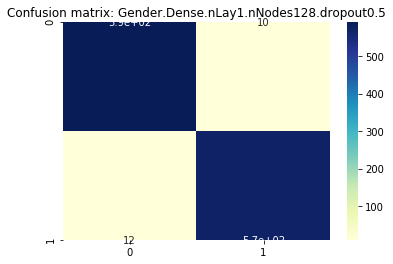

In [13]:
y1_lab, y1_pred = evaluate_model(model1, model1_name, test_dataset)

# Model 2
2 hidden layers, 128 and 64 nodes, respectively

In [14]:
# Set model parameters
n_layers = 2

# First layer will have 128 nodes, second layer will have 128/2 = 64 nodes
n_nodes = 128

model2_name = 'Gender.Dense.nLay{}.nNodes{}.dropout{}'.format(n_layers, n_nodes, DROPOUT)
model2_path = '../models/gender/{}'.format(model2_name)
ckpt2_name = '{}.ckpt'.format(model2_name)
ckpt2_path = '../models/gender/{}'.format(ckpt2_name)
ckpt2_dir = os.path.dirname(ckpt2_path)

In [15]:
if os.path.isdir(model2_path):
    model2 = tf.keras.models.load_model(model2_path)
    print("Saved model loaded")
    model2.summary()
elif os.path.isdir(ckpt2_path):
    model2 = create_gender_model(n_layers, n_nodes)
    model2.load_weights(ckpt2_path)
    print("Model weights loaded")
    model2.summary()

Saved model loaded
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (32, 10, 128)             16512     
_________________________________________________________________
dropout_2 (Dropout)          (32, 10, 128)             0         
_________________________________________________________________
dense_5 (Dense)              (32, 10, 64)              8256      
_________________________________________________________________
dropout_3 (Dropout)          (32, 10, 64)              0         
_________________________________________________________________
flatten_2 (Flatten)          (32, 640)                 0         
_________________________________________________________________
dense_6 (Dense)              (32, 1)                   641       
Total params: 25,409
Trainable params: 25,409
Non-trainable params: 0
_______________________________

In [16]:
test2_loss, test2_acc, test2_prec, test2_recall = model2.evaluate(test_dataset, steps=EVAL_STEPS)

37/37 [==============================] - 332s 9s/step - loss: 0.0770 - accuracy: 0.9755 - precision: 0.9602 - recall: 0.9914


tf.Tensor(
[[576  24]
 [  5 579]], shape=(2, 2), dtype=int32)


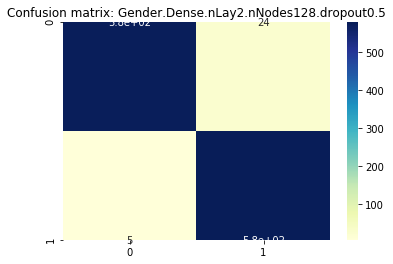

In [17]:
y2_lab, y2_pred = evaluate_model(model2, model2_name, test_dataset)

## Calculate F1 scores

In [20]:
m1_f1_micro = f1_score(y1_lab, y1_pred, labels = [0,1], average='micro')
m1_f1_macro = f1_score(y1_lab, y1_pred, labels = [0,1], average='macro')
m1_f1_weight = f1_score(y1_lab, y1_pred, labels = [0,1], average='weighted')

In [21]:
m2_f1_micro = f1_score(y2_lab, y2_pred, labels = [0,1], average='micro')
m2_f1_macro = f1_score(y2_lab, y2_pred, labels = [0,1], average='macro')
m2_f1_weight = f1_score(y2_lab, y2_pred, labels = [0,1], average='weighted')

# Store results in a dataframe

In [22]:
compare = pd.DataFrame({'loss': [test1_loss, test2_loss], 'accuracy': [test1_acc, test2_acc], 
                        'precision': [test1_prec, test2_prec], 'recall': [test1_recall, test2_recall],
                       'layers':[1, 2], 'nodes':[128, (128, 64)],
                       'F1 micro': [m1_f1_micro, m2_f1_micro], 'F1 macro': [m1_f1_macro, m2_f1_macro],
                       'F1 weighted': [m1_f1_weight, m2_f1_weight]},
                      index = ['model 1', 'model 2'])
compare.head()

,loss,accuracy,precision,recall,layers,nodes,F1 micro,F1 macro,F1 weighted
model 1,0.061640,0.981419,0.982818,0.979452,1,128,0.981419,0.981415,0.981418
model 2,0.076962,0.975507,0.960199,0.991438,2,"(128, 64)",0.975507,0.975507,0.975506


In [23]:
compare.to_csv('../models/gender/model_comparison.csv')